 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Theano-Implementation" data-toc-modified-id="Theano-Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Theano Implementation</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-a-single-day" data-toc-modified-id="Train-for-a-single-day-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train for a single day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-full-period" data-toc-modified-id="Train-for-full-period-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train for full period</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Keras-implementation" data-toc-modified-id="Keras-implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Keras implementation</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Predict-for-one-day" data-toc-modified-id="Predict-for-one-day-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Predict for one day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Predict-for-the-whole-period" data-toc-modified-id="Predict-for-the-whole-period-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Predict for the whole period</a></span></li></ul></li></ul></div>

# EMOS Network

In [264]:
# Imports
from importlib import reload
import emos_network_theano; reload(emos_network_theano)
from  emos_network_theano import EMOS_Network, crps_cost_function
import utils; reload(utils)
from utils import *
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [152]:
# Basic setup
DATA_DIR = '/Users/stephanrasp/repositories/ppnn/data/'  # Mac
fn = 'data_interpolated.nc'
window_size = 25
fclt = 48
utc = 0

## Theano Implementation

### Train for a single day

In [149]:
# Get the full dataset for 00UTC
tobs_full, tfc_full, dates = load_nc_data(DATA_DIR + fn, utc=utc)

In [224]:
# Just pick a day
date_idx = np.where(dates == datetime(2015, 6, 1, 0, 0))[0][0]
date_idx

3071

In [225]:
# Get the data slice for this particular date
tfc_mean_train, tfc_std_train, tobs_train, \
    tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            window_size, fclt)

In [226]:
# Define some model parameters
lr = np.asarray(0.1, dtype='float32')   # The learning rate
early_stopping_delta = 1e-4   # How much the CRPS must improve before stopping
steps_max = 1000   # How many steps to fit at max

In [243]:
# Set up the theano model
model_theano = EMOS_Network()

In [244]:
# Train the model for some steps
model_theano.fit(tfc_mean_train, tfc_std_train, tobs_train, steps_max, 
          (tfc_mean_test, tfc_std_test, tobs_test), lr=lr, 
          early_stopping_delta=early_stopping_delta)
# Output is the training CRPS and the test CRPS

(array(1.1621002564583596), array(0.9137559142044587))

### Train for full period

In [180]:
# Get start and stop indices
date_idx_start = np.where(dates == datetime(2008, 1, 1, 0, 0))[0][0]
date_idx_stop = np.where(dates == datetime(2016, 12, 31, 0, 0))[0][0]
date_idx_start, date_idx_stop

(363, 3650)

In [181]:
model_theano = EMOS_Network()

In [182]:
train_crps_list, valid_crps_list = loop_over_days(
    model_theano,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='EMOS_Network_theano')

400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
Time: 207.37 s


In [183]:
# Let's see what the mean prediction CRPS is
np.mean(valid_crps_list)

1.0558042002237267

The standard EMOS global score (in `standard_postprocessing/emos_global.R`) is 1.0654. So we are doing a little better even, but this might just be chance.

## Keras implementation

First, let's build the same model in Keras.

In [200]:
# import the keras modules
# Note that the cost function only works with the theano backend
import keras
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [187]:
# Let's build the model with Keras' functional API
# This is quite a bit easier and shorter than in theano 
# But it did take me some time to figure out the cost function, etc.
def build_EMOS_Network_keras():
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='linear')(mean_in)
    std_out = Dense(1, activation='linear')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    return Model(inputs=[mean_in, std_in], outputs=x)

In [245]:
model_keras = build_EMOS_Network_keras()

In [246]:
model_keras.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_42 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
dense_41 (Dense)                 (None, 1)             2           input_41[0][0]                   
____________________________________________________________________________________________________
dense_42 (Dense)                 (None, 1)             2           input_42[0][0]                   
___________________________________________________________________________________________

In [247]:
# Compile the model with SGD initilalizer
opt = SGD(lr=0.1)  
model_keras.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

### Predict for one day

In [248]:
# This way we have the gradient descent on the whole training set just as in theano
batch_size = tfc_mean_train.shape[0]   

In [249]:
h = model_keras.fit([tfc_mean_train, tfc_std_train], tobs_train, epochs=steps_max, batch_size=batch_size,
          validation_data=[[tfc_mean_test, tfc_std_test], tobs_test], verbose=0,
          callbacks=[EarlyStopping(monitor='loss', min_delta=early_stopping_delta,
                                  patience=2)])

In [250]:
model_keras.evaluate([tfc_mean_train, tfc_std_train], tobs_train, batch_size=64)

   64/12343 [..............................] - ETA: 0s

[1.2517586752240233, 1.2517586752240233]

In [251]:
model_keras.evaluate([tfc_mean_test, tfc_std_test], tobs_test, batch_size=64)

 64/495 [==>...........................] - ETA: 0s

[1.0580770378143314, 1.0580770378143314]

Se we get slightly better results than with the theano model above. This might be due to the differences in the early stopping algorithm.

In [252]:
len(h.history['loss'])

1000

In [253]:
# But I did notice something interesting looking at the history
valid_loss = h.history['val_loss']
train_loss = h.history['loss']

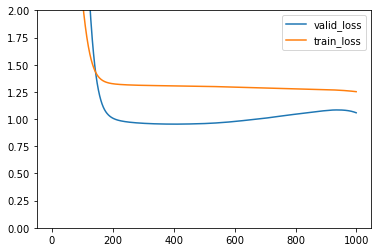

In [261]:
plt.plot(valid_loss, label='valid_loss')
plt.plot(train_loss, label='train_loss')
plt.legend()
plt.ylim(0, 2)
plt.show()

So this means we are overfitting a little. How could we avoid this. Let's pick a much longer training window.

In [255]:
# One year
tfc_mean_train, tfc_std_train, tobs_train, \
    tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            356, fclt)

In [256]:
batch_size = tfc_mean_train.shape[0]  

In [257]:
model = build_EMOS_Network_keras()
opt = SGD(lr=0.1)  
model.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

In [258]:
h = model.fit([tfc_mean_train, tfc_std_train], tobs_train, epochs=steps_max, batch_size=batch_size,
          validation_data=[[tfc_mean_test, tfc_std_test], tobs_test], verbose=0,
          callbacks=[EarlyStopping(monitor='loss', min_delta=early_stopping_delta,
                                  patience=2)])

In [259]:
model.evaluate([tfc_mean_test, tfc_std_test], tobs_test, batch_size=64)

 64/495 [==>...........................] - ETA: 0s

[1.0561385891911841, 1.0561385891911841]

Doesn't seem to change much. Which means that either we have compensating errors or the seasonal information doesn't mean much. Here are some ideas:
- Create an actual validation data set from the training data and use it for early stopping

### Predict for the whole period

In [265]:
model_keras = build_EMOS_Network_keras()
opt = SGD(lr=0.1)  
model_keras.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

In [266]:
train_crps_list, valid_crps_list = loop_over_days(
    model_keras,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='EMOS_Network_keras')

400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
Time: 291.84 s


So the keras implementation is quite a bit slower than the pure theano version. Maybe this is due to the overhead with calling fit many many times. Which one to keep??

In [269]:
train_crps_list

[[1.0596537571248619, 1.0596537571248619],
 [1.0665201209369861, 1.0665201209369861],
 [1.0615908925508049, 1.0615908925508049],
 [1.0743945832622437, 1.0743945832622437],
 [1.0879961302893177, 1.0879961302893177],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan

In [96]:
def fc_model():
    inp = Input(shape=(2,))
    x = Dense(2, activation='linear')(inp)
    return Model(inputs=inp, outputs=x)

In [97]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [108]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=crps_cost_function, metrics=[crps_cost_function])

In [109]:
in_train = np.column_stack([tfc_mean_train, tfc_std_train])
in_train.shape

(25190, 2)

In [110]:
in_test = np.column_stack([tfc_mean_test, tfc_std_test])

In [111]:
model.fit(in_train, tobs_train, epochs=1000, batch_size=25190, verbose=0)

In [112]:
model.fit(in_train, tobs_train, epochs=1, batch_size=25190,
          validation_data=[in_test, tobs_test], verbose=1)

Train on 25190 samples, validate on 506 samples
Epoch 1/1
25190/25190 [==============================] - 0s - loss: 1.2329 - crps_cost_function: 1.2329 - val_loss: 1.1481 - val_crps_cost_function: 1.1481
